In [1]:
import pandas as pd
from kan.custom_processing import (plot_data_per_interval,
                                   plot_activation_and_spline_coefficients, get_masks)
import matplotlib.pyplot as plt
import os
import datetime
import json
import numpy as np
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 75*10

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures")
time_stamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')

fn = "CO2RR_MSP_20251111_1016"
save_tag = fn + "_analysis"
save_heading = os.path.join(save_dir, save_tag)

df = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', fn + ".xlsx"), sheet_name='best_avg_by_params')
d_opt = df

d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}

In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

filepath = os.path.join("..\TaeWoong", "25.01.14_CO2RR_GSA.xlsx")

xls = pd.ExcelFile(filepath)
df_in = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)

removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")

name_X = [
    "Current density (mA/cm2)",
    "Faradaic efficiency (%)",
    "CO coversion",
    "Voltage (V)",
    "Electricity cost ($/kWh)",
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)",
    "Crossover rate"
]
name_y = "MSP ($/kgCO)"  # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)  # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train)  # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

This script is running on cpu.
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
--- 이상치 제거 완료 ---

전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)


| train_loss: 4.04e-03 | test_loss: 4.06e-03 | reg: 2.63e+00 | : 100%|█| 50/50 [00:29<00:00,  1.67it
| train_loss: 2.40e-03 | test_loss: 3.13e-03 | reg: 2.57e+00 | : 100%|█| 50/50 [00:36<00:00,  1.38it
| train_loss: 8.92e-03 | test_loss: 9.30e-03 | reg: 2.23e+00 | : 100%|█| 50/50 [00:25<00:00,  1.93it
| train_loss: 1.34e-02 | test_loss: 1.43e-02 | reg: 2.27e+00 | : 100%|█| 50/50 [00:28<00:00,  1.74it


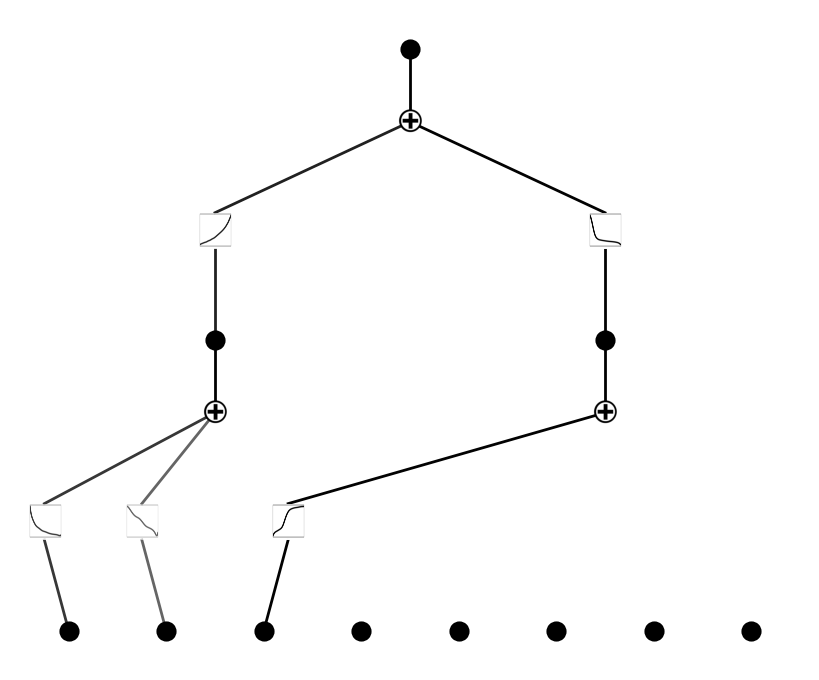

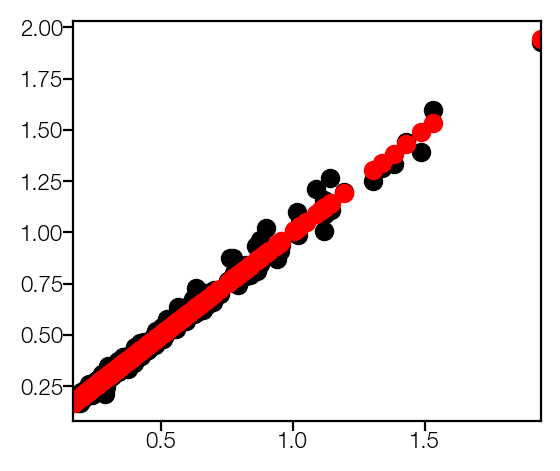

TrialResult(params={'lamb': 0.0001, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.1, 'lamb_entropy': 0.1, 'lr': 1, 'max_grid': 10, 'prune': True, 'pruning_th': 0.05, 'update_grid': True, 'width': [[8, 0], [8, 0], [1, 0]]}, val_loss=0.016529563814401627, train_loss=0.015821371227502823, test_loss=0.016941910609602928, r2_train=0.9903143116426635, r2_val=0.9905590106352908, r2_test=0.989985909371422, seed=0, device='cpu', spline_train_loss=0.018566817045211792, spline_test_loss=0.020305046811699867)


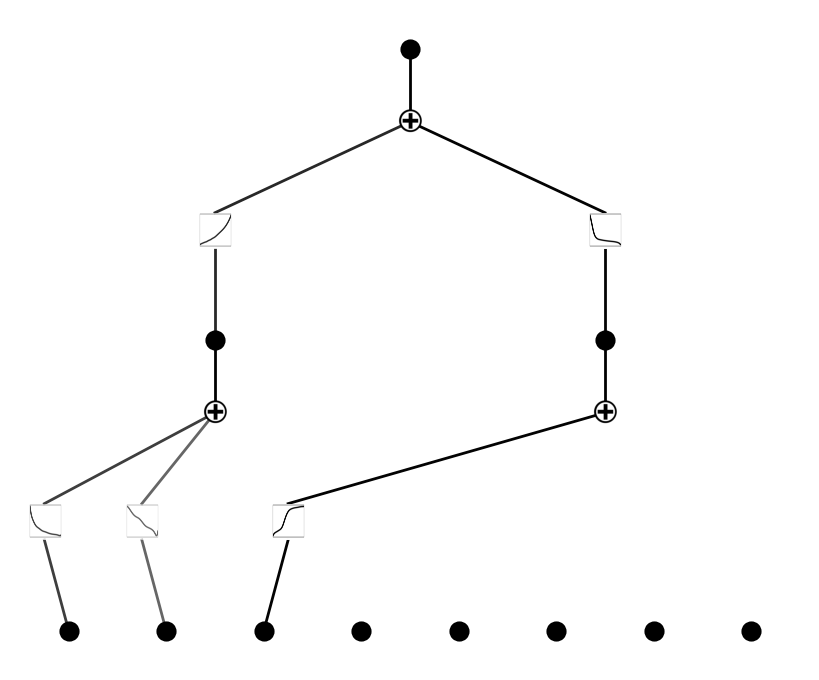

In [3]:
from kan.experiments.multkan_hparam_sweep import evaluate_params

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
print(res)
model.plot()
plt.show()

| train_loss: 3.39e-03 | test_loss: 3.52e-03 | reg: 2.86e+00 | : 100%|█| 50/50 [00:31<00:00,  1.58it
| train_loss: 3.34e-03 | test_loss: 3.77e-03 | reg: 2.62e+00 | : 100%|█| 50/50 [00:23<00:00,  2.16it
| train_loss: 7.76e-03 | test_loss: 7.79e-03 | reg: 2.23e+00 | : 100%|█| 50/50 [00:14<00:00,  3.43it
| train_loss: 1.34e-02 | test_loss: 1.42e-02 | reg: 2.15e+00 | : 100%|█| 50/50 [00:18<00:00,  2.77it


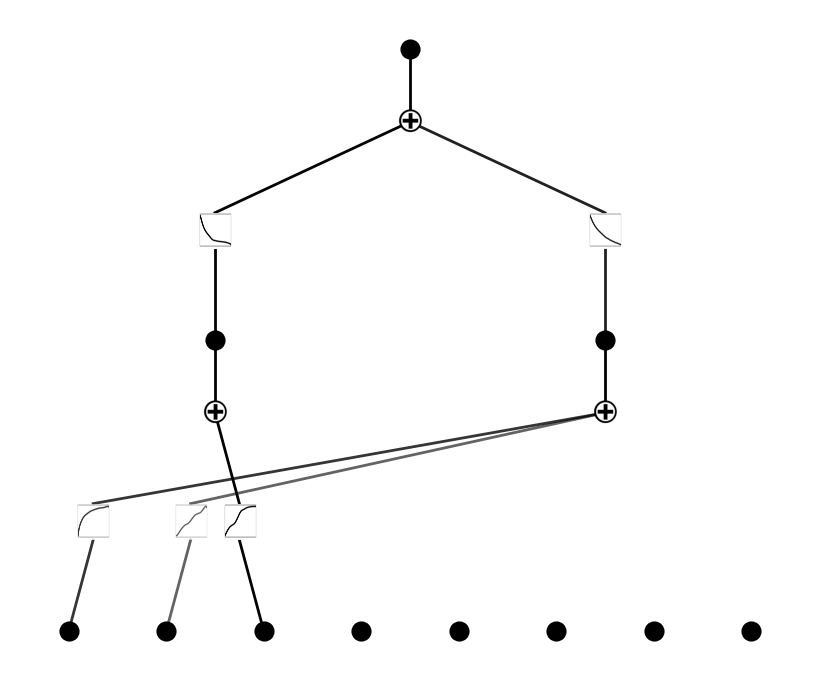

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,0) with 0
r2 is 0.9992561340332031
fixing (0,0,1) with 1/x, r2=1.0, c=2
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,1,0) with 0
Best value at boundary.
r2 is 0.9905811548233032
fixing (0,1,1) with x, r2=0.99, c=1
r2 is 0.9296880960464478
fixing (0,2,0) with x, r2=0.93, c=1
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,2,1) with 0
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,3,0) with 0
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,3,1) with 0
Best value at boundary.
r2 is 0.0
r2 is not very hig

| train_loss: 1.65e-02 | test_loss: 1.59e-02 | reg: 3.98e-01 | : 100%|█| 50/50 [00:12<00:00,  3.88it


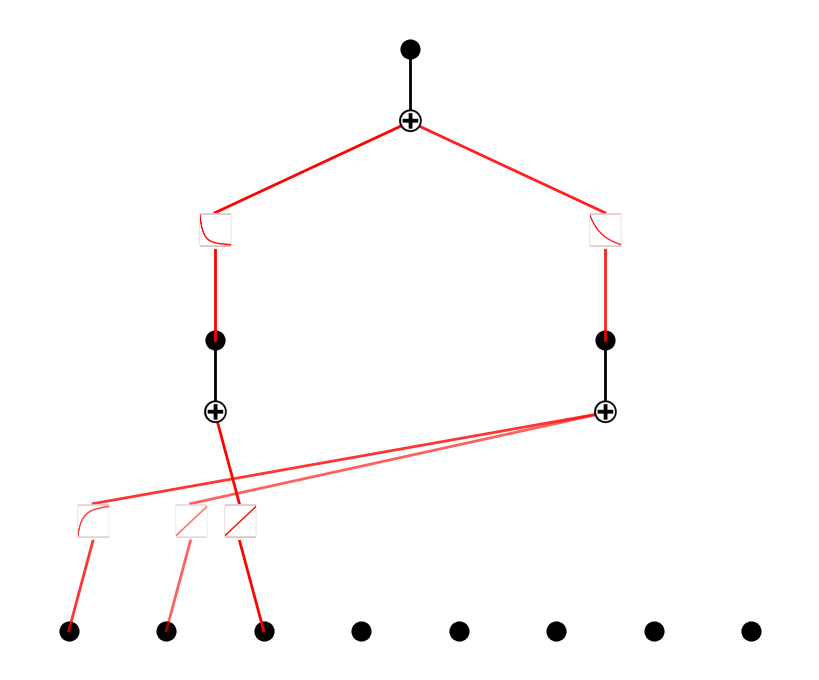

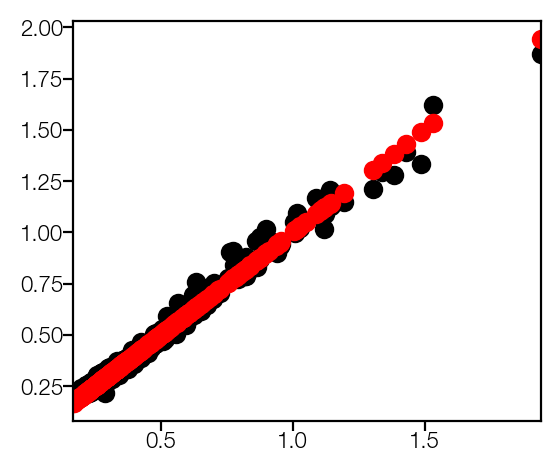

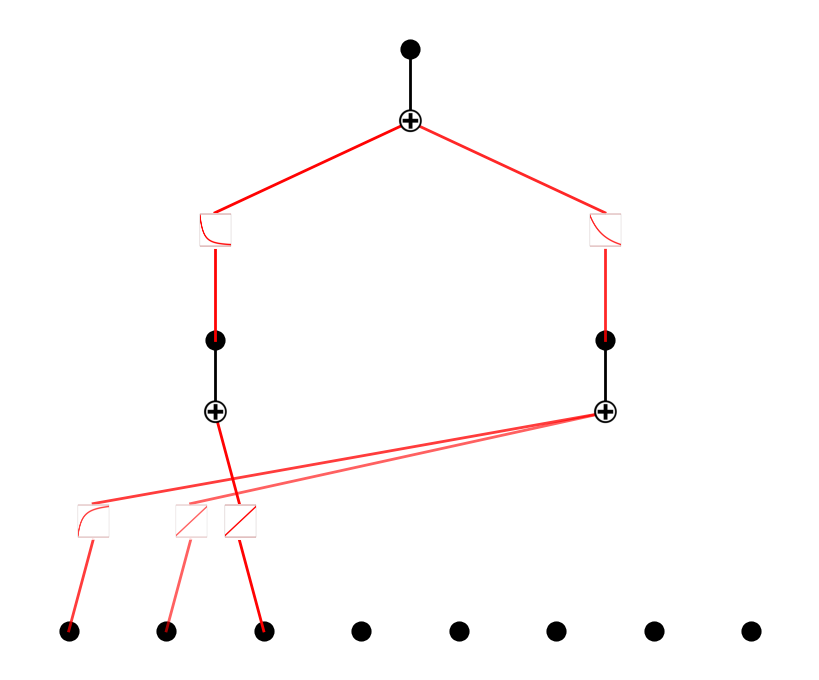

In [8]:
import copy

params_sym = copy.deepcopy(params)
params_sym['symbolic'] = True
# params_sym['sym_weight_simple'] = 0.

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params_sym, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
model.plot()
plt.show()

In [9]:
print(res)

TrialResult(params={'lamb': 0.0001, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.1, 'lamb_entropy': 0.1, 'lr': 1, 'max_grid': 10, 'prune': True, 'pruning_th': 0.05, 'update_grid': True, 'width': [[8, 0], [8, 0], [1, 0]], 'symbolic': True}, val_loss=0.02130497246980667, train_loss=0.020797759294509888, test_loss=0.020763784646987915, r2_train=0.9852552729813765, r2_val=0.9862923122184278, r2_test=0.9875108939802812, seed=0, device='cpu', spline_train_loss=0.013608759269118309, spline_test_loss=0.014315412379801273)


Text(0, 0.5, 'Attribution score')

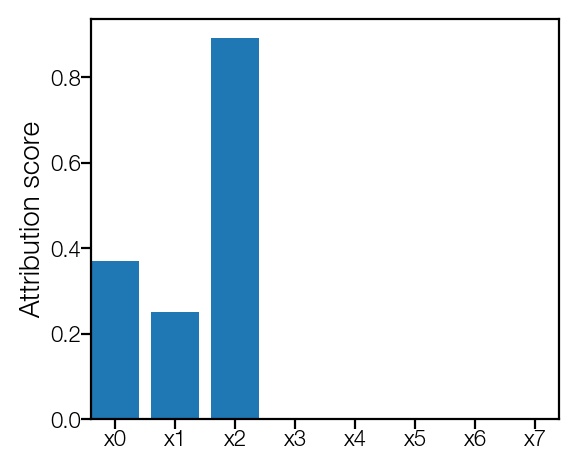

In [12]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

fig, ax = plt.subplots()
model.forward(torch.tensor(X_norm, dtype=torch.float32, device=device))
scores_tot = model.feature_score.detach().cpu().numpy()
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

0.7424471378326416


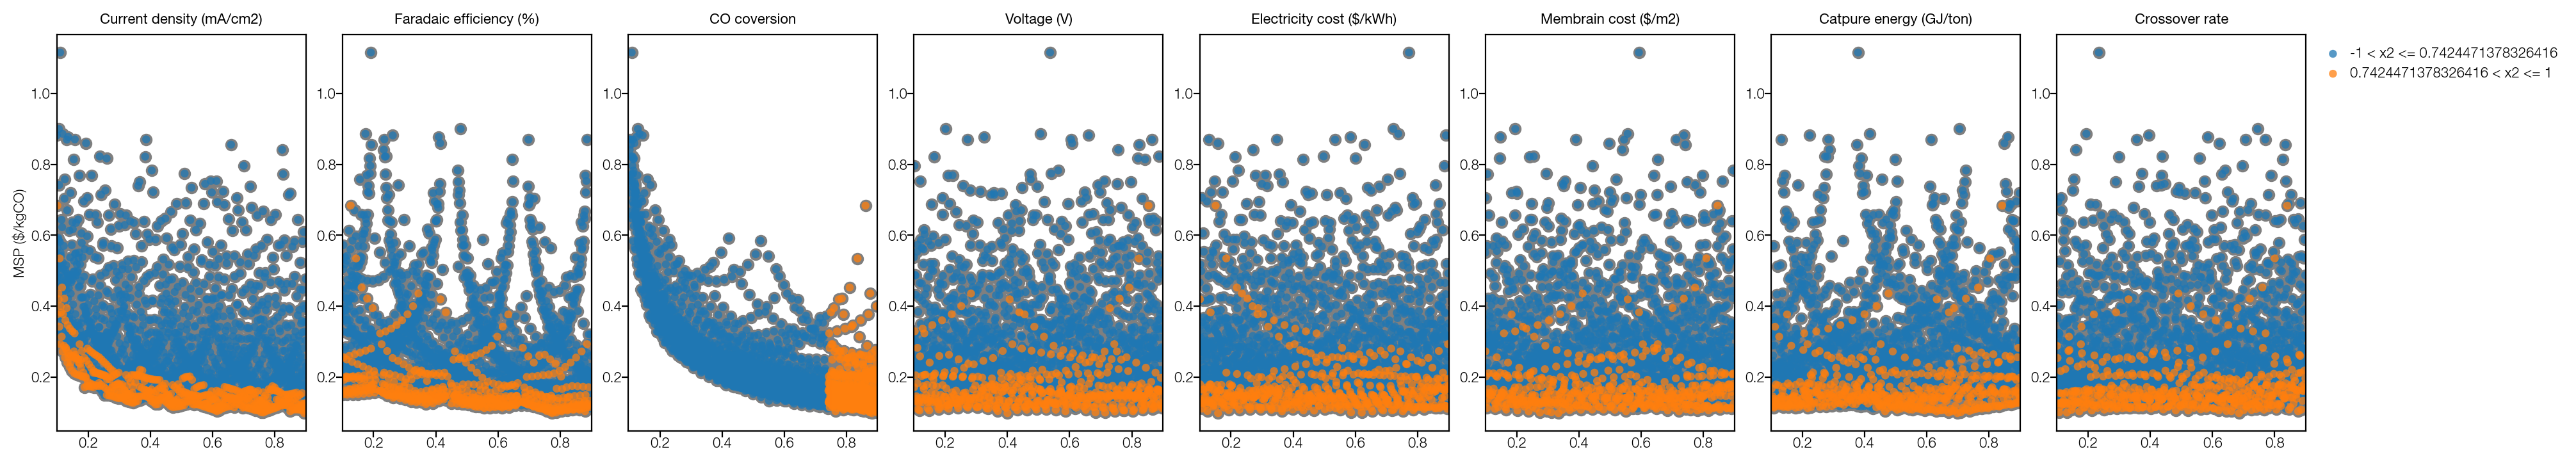

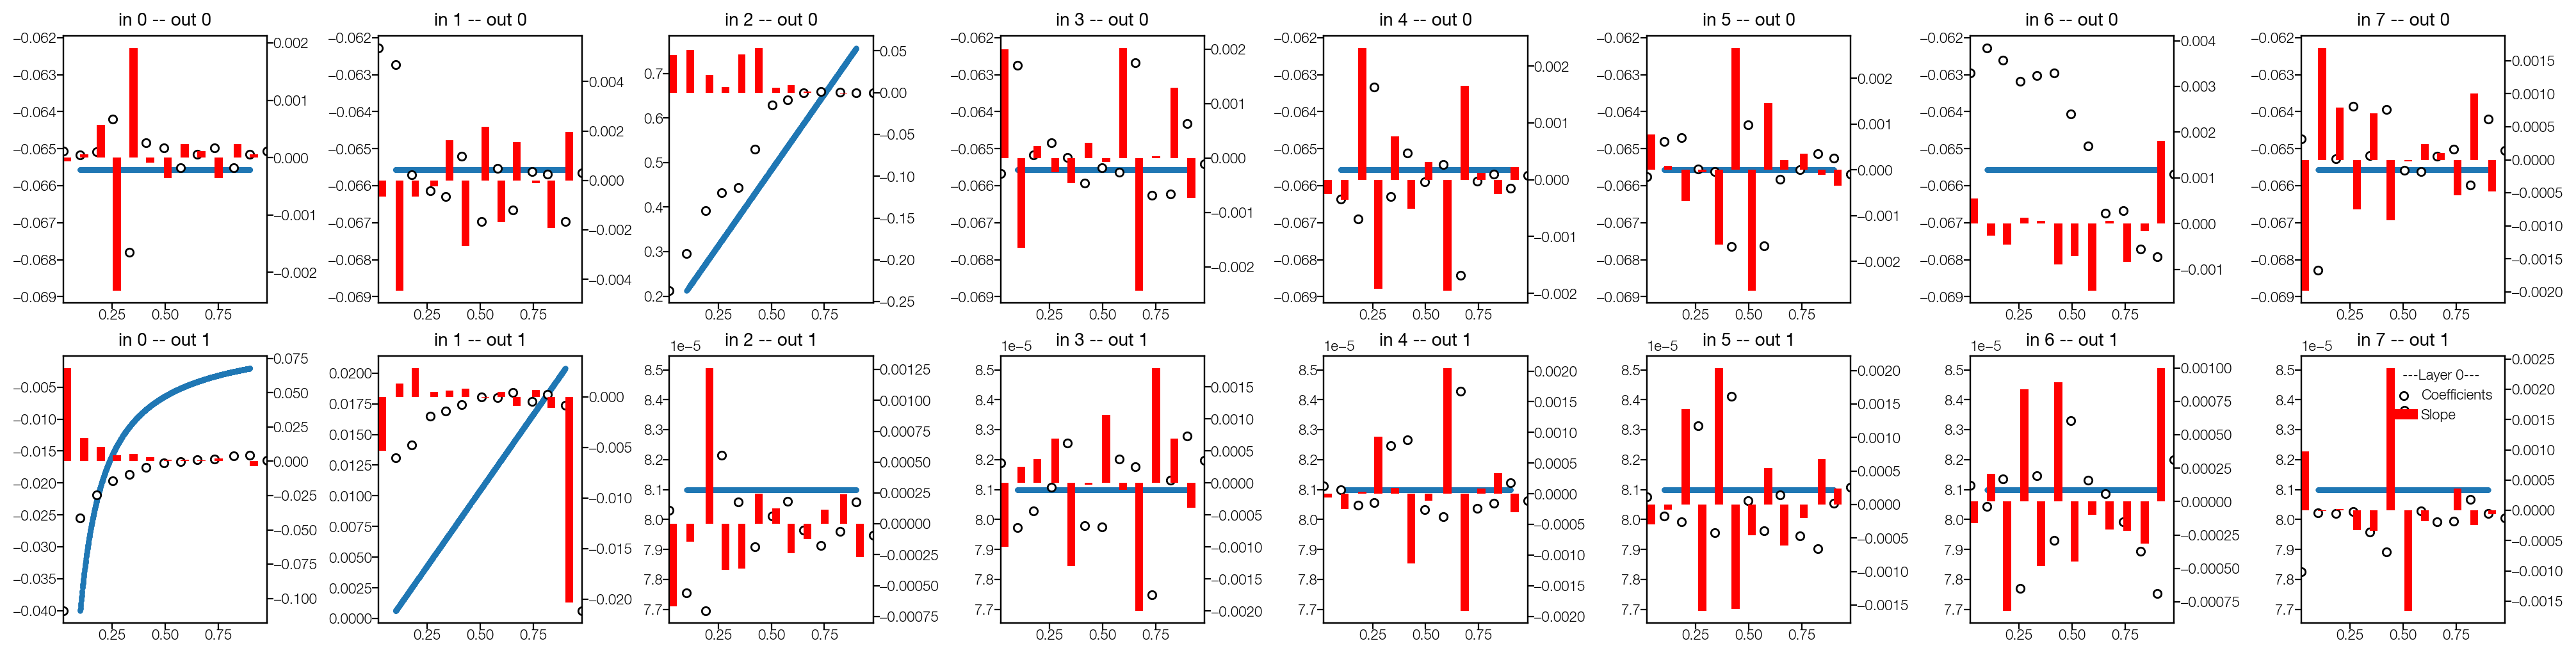

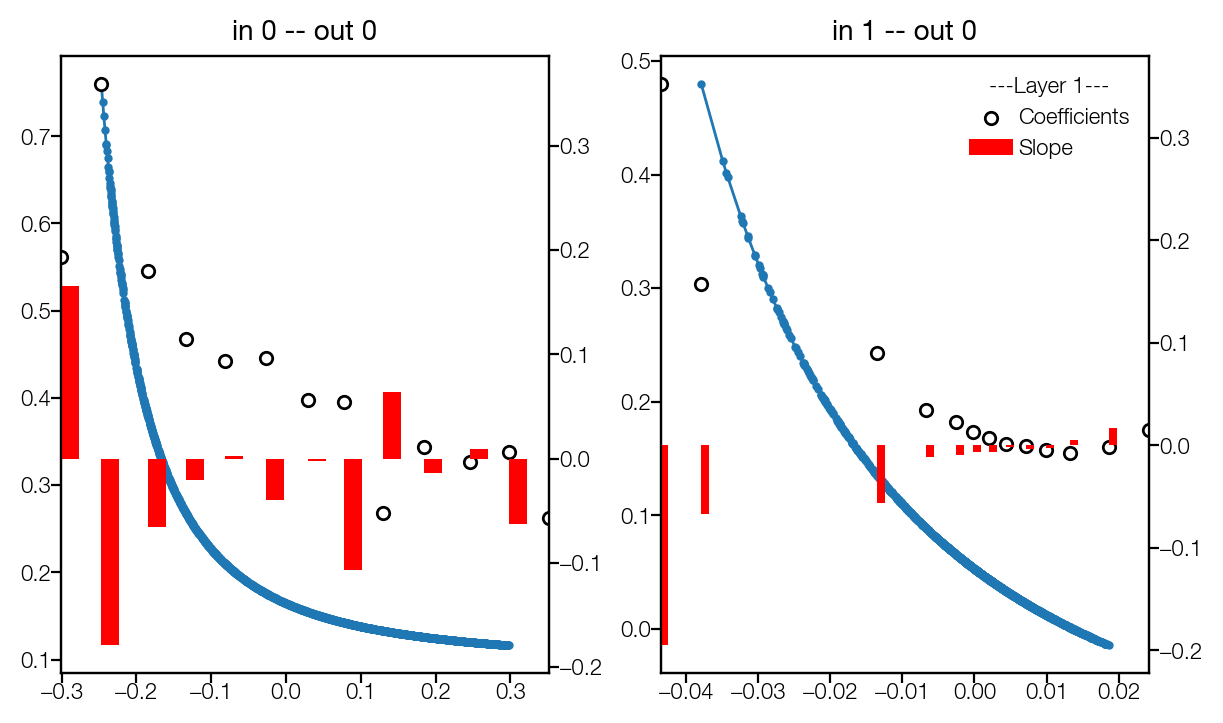

[<Figure size 4000x1000 with 32 Axes>, <Figure size 1200x700 with 4 Axes>]

In [18]:
from kan.custom_processing import plot_data_per_interval, find_index_sign_revert
from kan.experiments.multkan_hparam_sweep import _build_dataset

l = 0
act = model.act_fun[l]
ni, no = act.coef.shape[:2]
coef = act.coef.tolist()
inflection_points_per_input = []

for i in range(ni):
    for j in range(no):
        coef_node = coef[i][j]
        num_knot = act.grid.shape[1]
        spline_radius = int((num_knot - len(coef_node)) / 2)

        slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
        slope_2nd = [(x - y) * 10 for x, y in zip(slope[1:], slope[:-1])]

        idx_sign_revert = find_index_sign_revert(slope)
        if idx_sign_revert is None:
            inflection_points_per_input.append(None)
        else:
            inflection_val = act.grid[i, spline_radius + find_index_sign_revert(slope)]
            inflection_points_per_input.append(inflection_val)

mask_idx = np.argmax(scores_tot)
mask_inflection_val = inflection_points_per_input[mask_idx].item()
mask_interval = [-1, mask_inflection_val, 1]

fig_x2, axs_x2 = plot_data_per_interval(X_norm, y_norm, name_X, name_y, mask_idx, mask_interval)

dataset = _build_dataset(X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm, device)
plot_activation_and_spline_coefficients(model, save_heading=save_heading, x=dataset, layers=None)

[1905, 473]


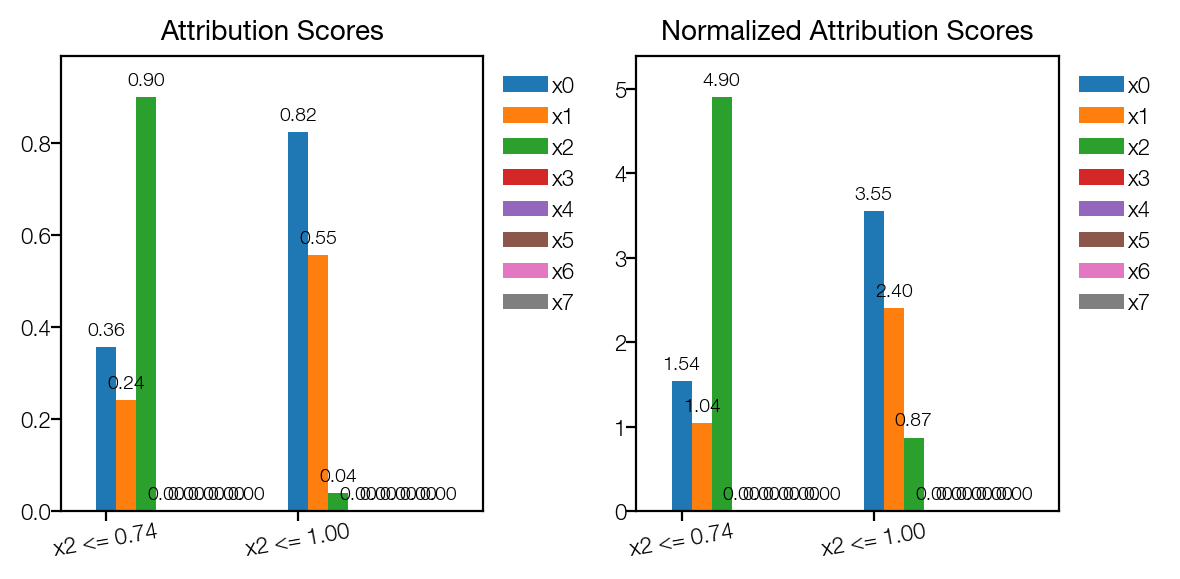

In [20]:
masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'x{mask_idx} <= {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_normalized = []
for mask in masks:
    if np.any(mask):
        x_masked = X_norm[mask, :]
        x_tensor_masked = torch.tensor(x_masked, dtype=torch.float32, device=device)
        model.forward(x_tensor_masked)

        std = x_tensor_masked.std(dim=0)
        score = model.feature_score.detach().cpu().numpy()
        score_norm = score / std
        scores_interval.append(score)
        scores_interval_normalized.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_normalized.append(np.zeros(scores_tot.shape))

width = 0.25
fig, axs = plt.subplots(1, 2, figsize=(6,3))

ax = axs[0]
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
ax.set_title("Attribution Scores")
plt.tight_layout()

ax_norm = axs[1]
max_score = max([max(s) for s in scores_interval_normalized])
for idx in range(scores_tot.shape[0]):
    bars = ax_norm.bar(xticks + idx * width, [s[idx] for s in scores_interval_normalized], width, label=f"x{idx}")
    ax_norm.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax_norm.margins(x=0.1)
ax_norm.set_ylim(0, max_score * 1.1)

ax_norm.set_xticks(xticks)
ax_norm.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax_norm.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
ax_norm.set_title("Normalized Attribution Scores")

plt.tight_layout()
plt.show()

In [21]:
torch.save(model.state_dict(), f"{save_heading}_model.pt")